<a href="https://colab.research.google.com/github/kaitany/NLP_PROJECT/blob/main/Fine_tuning_Hugging_face_text_classification_model_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Sentiment Analysis with Hugging Face**

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## **Application of Hugging Face Text classification model Fune-tuning**

Find below a simple example, with just `5 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

In [1]:
#Install required dependencies

#!pip install -q transformers

!pip install -q transformers
!pip install -q accelerate -U
!pip install -q datasets   #the -q 'quiet' option to suppress output and warnings.
!pip install -q huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.7 MB/s eta 0:00:00


## **IMPORTATION**

In [2]:
#Load necessary libraries
import os
import pandas as pd
import numpy as np
#import torch
from scipy.special import softmax
import re
#Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud  # Import the WordCloud class
#skikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#Data preparation
from datasets import load_dataset, load_metric #import load_dataset function & load_metric function for evaluation
#Transformers
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, DataCollatorWithPadding, AutoConfig
#Huggingface
from huggingface_hub import notebook_login

import warnings
#ignore warnings
warnings.filterwarnings("ignore")
#Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

## **DATA LOADING**

In [4]:
#Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Navigate to the Colab Notebooks/NLP_Data folder
%cd drive/MyDrive/"Colab Notebooks"/NLP_Data

/content/drive/MyDrive/Colab Notebooks/NLP_Data


In [6]:
# Load train and test datasets from NLP_Data folder
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP_Data/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP_Data/Test.csv')

## **DATA UNDERSTANDING AND EDA**

In [7]:
#Preview of first five rows on the train data
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [8]:
#Preview of last five rows on the test data
test.tail()

,tweet_id,safe_text
5172,ZXVVNC5O,jenny mccarthy is on new years rockin eve. wha...
5173,ZYIANVI8,Measles reported in Clark Co. for 1st time sin...
5174,ZYITEHAH,<user> issues alert regarding Measles in TX. K...
5175,ZZ3BMBTG,I can't believe people don't vaccinate their k...
5176,ZZIYCVNH,"""<user> Alternatives to #Flu Vaccine <url> #n..."


In [9]:
#Check the shape(No. of rows and columns) in both the train and test sets
print(train.shape, test.shape)

(10001, 4) (5177, 2)


In [10]:
#Information summary of train set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   10001 non-null  object 
 1   safe_text  10001 non-null  object 
 2   label      10000 non-null  float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 312.7+ KB


In [11]:
#Information summary of test set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5177 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


In [12]:
#Check for missing values in train data
train.isna().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [13]:
#Check for missing values in test data
test.isna().sum()

tweet_id     0
safe_text    1
dtype: int64

In [14]:
#Any duplicates in both train and test data sets?
train.duplicated().sum()

0

In [15]:
#There were no duplicates in both train and test data sets
test.duplicated().sum()

0

In [16]:
#Check for label distribution
train['label'].value_counts()

 0.000000    4908
 1.000000    4053
-1.000000    1038
 0.666667       1
Name: label, dtype: int64

In [17]:
#check for data quality
train['safe_text'].sample(10)

4779    Yup, this and whooping cough was all a grand t...
8030    The CDC says they could have already developed...
3367    <user> those that are concerned that vaccinati...
6278    I was there MT <user> 61yrs ago today mass ino...
4721    <user> If you get a measles shot, this shouldn...
27      I'm not obsessed w Ebola, just following an ou...
6283    #SFBayArea: Get yourself vaccinated against me...
1251    When you take your child to kindergarten, you ...
2689    <user> YES! Let's Make HPV Vaccination a Publi...
9223    Some great news. "#Measles #vaccine attacks #c...
Name: safe_text, dtype: object

### ***DATA QUALITY ISSUES***
1.The label, agreemet, and safe_text columns contain missing values.

2.The safe_text column contains usernames, emojis, hashtags, and URLs. These elements might introduce noise into the data and distract the model from the main message.

3.Varying text lengths in safe_text column. Tweets vary in length from very short to longer messages. Deep learning models typically work with fixed input sizes and there is need to preprocess the text data to handle varying text lengths.

4.The safe_text column contains trailing white spaces and multiple consecutive spaces between text that can affect the performance of a deep learning model.

## **DATA CLEANING**

In [18]:
#Create a function to apply in the cleaning process

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    #Remove word url
    #text = text.replace("url", "")
    text = re.sub(r'url|\r\n', '', text)

    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Remove mentions
    text = re.sub(r'<user>','', text)

    # Remove special characters and hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)

    # Remove multiple consecutive spaces
    text = re.sub(r'\s*$', ' ', text) #removes trailing spaces at the end of the text

    text = re.sub(r'^\s+', '', text) #removes consecutive leading spaces at the beginning of the text

    # Strip leading and trailing white spaces
    text = text.strip()

    return text

In [19]:
#Apply the clean_text function to the 'safe_text' column
train['safe_text'] = train['safe_text'].apply(clean_text)

In [23]:
#Are changes effected?
train['safe_text'].sample(10)

9170    Federal court has vindicated Snowden as a whis...
6292    Another one As the CDC says 36 states see high...
6852    SWOG breast cancer committee now committed to ...
3296    60 million doses of HPV given in the US Its sa...
9774    SOLS school of life sciences  seminar three sp...
9807    In a catch 22 Seems like everyone is 100 sure ...
1697    Superstition again battles with truth Vaccines...
5114    yeah im like a vaccineim the disease but a wea...
259     SB121 Passed Meningococcal diseasepupils to be...
7861    Syrian children in Aleppo are demanding Santa ...
Name: safe_text, dtype: object

### **Remove Missing values**

In [24]:
#Drop all Missing values in train & test set
train.dropna(inplace = True)

test.dropna(inplace = True)

In [25]:
#Confirm changes in train set
train.isnull().sum()


tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

## **TEXT ANALYSIS**

### **WORD CLOUDS**
*   To visualize the most common words in positive, negative, and neutral tweets using word clouds.

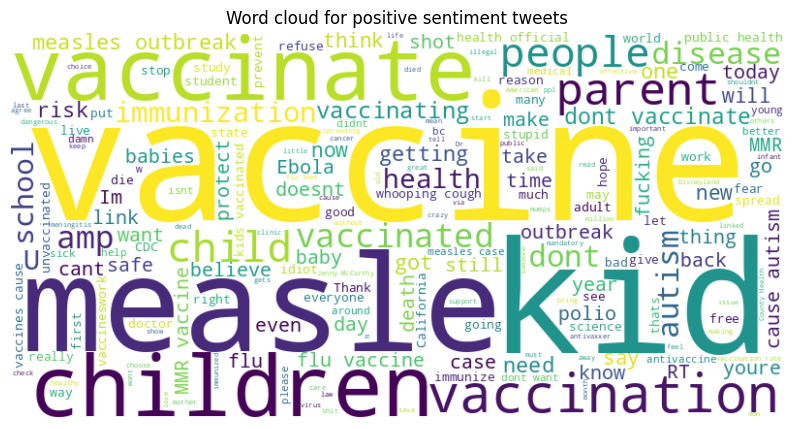

In [26]:
#Word counts in positive tweets
positive_tweets = train[train['label']==1]['safe_text']

#Generate and display a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(''.join(positive_tweets))

#Set the fig size
plt.figure(figsize=(10,6))

plt.imshow(wordcloud, interpolation='bilinear')

#Set Axis off
plt.axis('off')

#Set plot title
plt.title('Word cloud for positive sentiment tweets')

#Show plot
plt.show()

 This visualization is a graphical representation of the most frequently occurring words in positive sentiment tweets.

 The size of each word in the cloud is proportional to its frequency. Words that appear more frequently in the text are displayed in a larger font size.

* Notably, terms related to vaccination and health, such as "vaccine", "measle", "vaccination", and "vaccinate", indicating the central focus of the dataset.
* The words "kid", "child" and "children" with large font size indicate a lot of discussion and talk concerning vaccination of children.







### **DISTRIBUTION OF TEXT LENGTH**

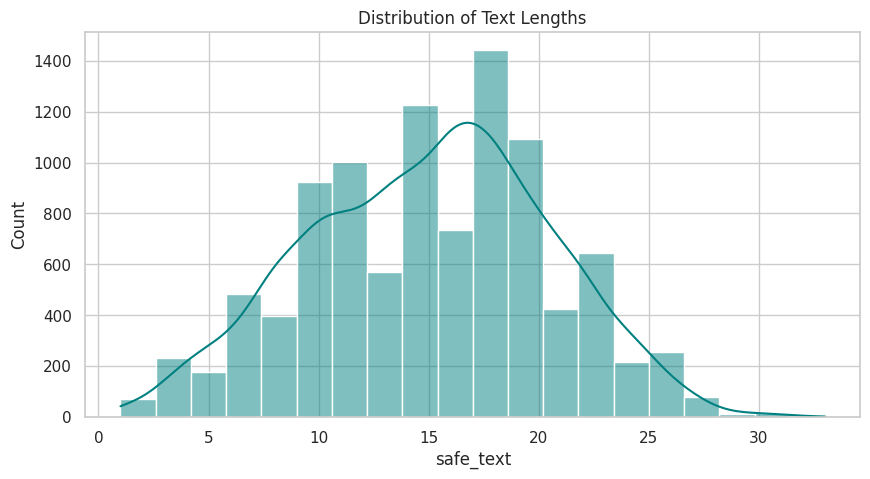

In [27]:
#Calculate the lenths(No. of words) in the 'safe_text' column
text_lengths = train['safe_text'].apply(lambda x: len(x.split()))

#Set the style for Seaborn
sns.set(style='whitegrid')

#Show figure size
plt.figure(figsize=(10, 5))

#Create histogram using seaborn
sns.histplot(text_lengths, bins=20,kde=True, color="teal")

#Set plot title
plt.title('Distribution of Text Lengths')

#Display plot
plt.show()


The Histogram of text lengths represents the distribution of the number of words in the text data.  Each bar on the Histogram corresponds to a range of text lengths and the height of each bar represents the count of tweets falling into that range.

*   Looking at the Histogram, we can observe that most tweets have a text length in the range of approximately 10 to 20 words.

*   The Histogram provides a visual summary of the distribution of text lengths. It provides an at-a-glance overview of the typical text length within the dataset. The information derived from the Histogram is valuable for various purposes, such as setting the maximum sequence length for text preprocessing in a sentiment analysis model. Choosing an appropriate sequence length ensures that you capture the most relevant information from the text data without making the sequences too long or too short.





### **SENTIMENT LABEL DISTRIBUTION**

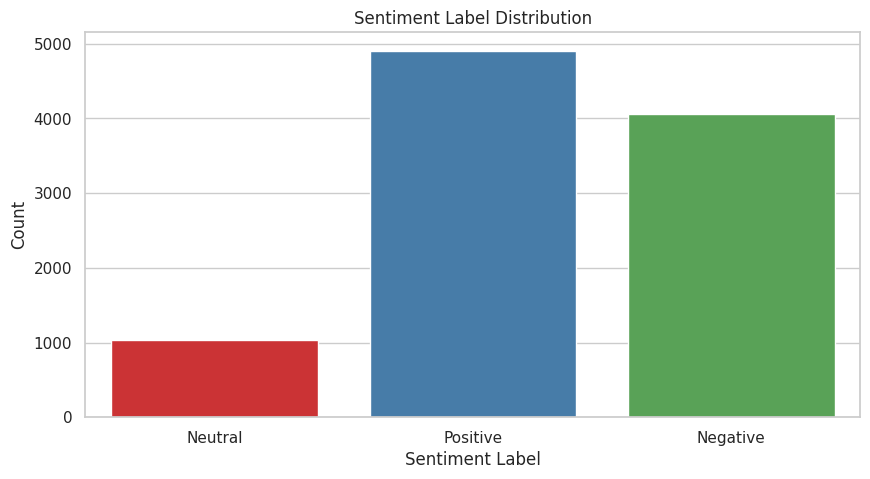

In [28]:
#Create a bar plot
# Map the numeric labels to their corresponding sentiment labels
label_mapping = {0: 'Neutral', 1: 'Positive', -1: 'Negative'}

plt.figure(figsize=(10,5)) #Set the plot figure size

sns.countplot(data=train, x='label', palette='Set1') #use searborns sns.countplot() to plot a bar graph

plt.title('Sentiment Label Distribution')  #Set the plot title

plt.xlabel('Sentiment Label') #Label for the x-axis

plt.ylabel('Count') #Label for the y-axis

# Customize and emphasize x-axis labels using the label_mapping
plt.xticks(ticks=[0, 1, 2], labels=[label_mapping[label] for label in [0, 1, -1]]) #makes the plot more informative and easier to interpret.

plt.show() #Display the plot


The count plot visually represents the distribution of sentiments in the dataset. It uses bars to represent the different sentiment labels and their respective counts.

The height of each bar in the plot directly corresponds to the count of tweets associated with a specific sentiment label.

1.   Neutral (0.0): 4908 occurences
2.   Positive (1.0): 4053 occurences
3.   Negative (-1.0): 1038 occurences

This plot provides valuable insights into the overall sentiment distribution. It highlights that "neutral" sentiments are the most prevalent, closely followed by "positive" sentiments, and "Negative" sentiments are relatively less frequent in the dataset.




## **DATA PREPROCESSING**

### **Lowercasing**


Lowercasing is done to ensure that all the text in the "safe_text" column is in a consistent case. i.e Lowercase. Lowercasing ensures that tokens like "Vaccine" and "VACCINE" are treated as the same token.

In [29]:
train['safe_text'] = train['safe_text'].str.lower()

###### **TRAIN VALIDATION SPLIT**

I manually split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).


In [30]:
# Split the train data => {train, eval}
#Split with 20% evaluation set size

train, eval = train_test_split(train, test_size=0.2, random_state=42, stratify=train['label'])

In [31]:
#Check the shape (number of row and columns) of the splitted datasets
print(f"datasets shapes after the split:")
print(f"train is {train.shape}")
print(f"eval is {eval.shape}")

datasets shapes after the split:
train is (7999, 4)
eval is (2000, 4)


In [32]:
# Save the training and evaluation sets for reproducibility
# Save the data to a CSV file
train.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP_Data/train_subset.csv', index=False)
eval.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP_Data/eval_subset.csv', index=False)

#### **PREPARE DATASETS**

In [33]:
## Update the file paths to point to your Google Drive
dataset = load_dataset(path='csv',
                        data_files={'train': '/content/drive/MyDrive/Colab Notebooks/NLP_Data/train_subset.csv',
                        'eval': '/content/drive/MyDrive/Colab Notebooks/NLP_Data/eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [34]:
#Chech if loading is succcessful
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'safe_text', 'label', 'agreement'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['tweet_id', 'safe_text', 'label', 'agreement'],
        num_rows: 2000
    })
})

In [35]:
#Define the model name to be used for tokenization and modeling

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

## Create an instance of the Twitter-roBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [36]:
#Transform the labels
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative' sentiment
        num = 0
    elif label == 0: #'Neutral' sentiment
        num = 1
    elif label == 1: #'Positive' sentiment
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding=True)

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [38]:
# Loading pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
#training_args = TrainingArguments("test_trainer", num_train_epochs=3000, load_best_model_at_end=True,)

#Define training arguments with 3 epochs
batch_size = 4
training_args = TrainingArguments(
    output_dir = "finetuned-roberta-base-sentiment",
    num_train_epochs=3,
    load_best_model_at_end=True,
    per_device_train_batch_size = 10,
    per_device_eval_batch_size = 10,
    logging_steps = batch_size,
    evaluation_strategy="epoch",  # Match the evaluation strategy with epoch strategy
    save_strategy="epoch", # Match the save strategy with epoch strategy
    learning_rate = 2e-5,
    weight_decay=0.02,
    push_to_hub = True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [40]:
#from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(y_true=labels, y_pred=predictions, average='weighted')
    return {"f1": f1}

In [41]:
#Instantiate the training and evaluation sets with a random state of 12

train_dataset = dataset['train'].shuffle(seed=10)
eval_dataset = dataset['eval'].shuffle(seed=10)

In [42]:
notebook_login()

In [45]:
#Instantiate the trainer for training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True, return_tensors='pt')
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [46]:
# Launch the learning process: training
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.409400,0.518799,0.804581
2,0.348900,0.580753,0.790248
3,0.255600,0.711850,0.801675


TrainOutput(global_step=2400, training_loss=0.4580028241996964, metrics={'train_runtime': 413.9376, 'train_samples_per_second': 57.973, 'train_steps_per_second': 5.798, 'total_flos': 538082356055580.0, 'train_loss': 0.4580028241996964, 'epoch': 3.0})

Epoch 1 has lowest training loss of (0.409400) and the lowest validation loss of
(0.518799). Generally, lower training and validation loss is an indicator of a better-performing model because the model is not overfitting on the data.


#### **Visualization of training and validation loss over epochs**

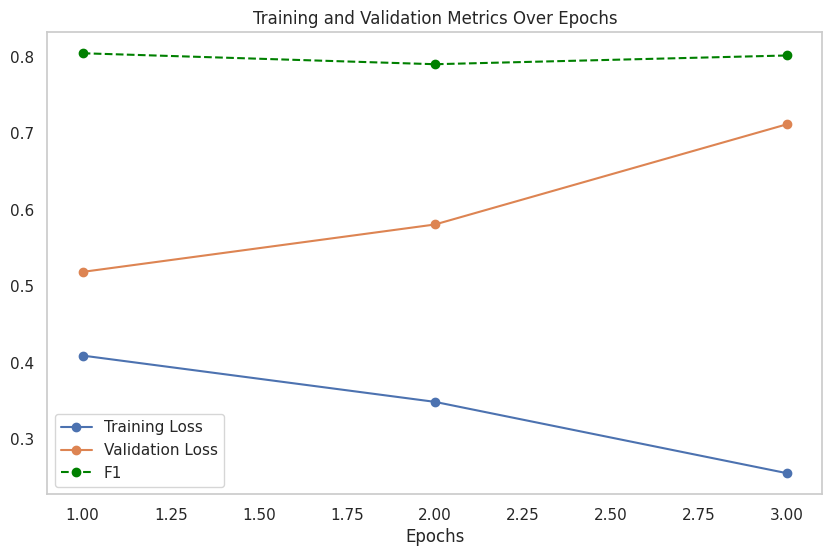

In [47]:
#import matplotlib.pyplot as plt

# data
epochs = [1, 2, 3]
training_loss = [0.409400, 0.348900, 0.255600]
validation_loss = [0.518799, 0.580753, 0.711850]
f1 = [0.804581, 0.790248, 0.801675]

# Create a single plot for all metrics
plt.figure(figsize=(10, 6))
plt.title("Training and Validation Metrics Over Epochs")
plt.xlabel("Epochs")
plt.grid()

# Plot Training Loss
plt.plot(epochs, training_loss, label='Training Loss', marker='o')

# Plot Validation Loss
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')

# Plot F1
plt.plot(epochs, f1, label='F1', marker='o', linestyle='--', color='green')

plt.legend()
plt.show()

In [48]:
# Launch the final evaluation
trainer.evaluate()

{'eval_loss': 0.518798828125,
 'eval_f1': 0.8045811479821863,
 'eval_runtime': 5.2479,
 'eval_samples_per_second': 381.107,
 'eval_steps_per_second': 38.111,
 'epoch': 3.0}

Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

Do not hesitate to read more and to ask questions, the Learning is a lifelong activity.

In [ ]:
notebook_login()

In [49]:
trainer.push_to_hub("finetuned-roberta-base-sentiment")

events.out.tfevents.1699370351.a1b71b828d79.320.1:   0%|          | 0.00/405 [00:00<?, ?B/s]

'https://huggingface.co/KAITANY/finetuned-roberta-base-sentiment/tree/main/'

In [ ]:
tokenizer.push_to_hub("finetuned-roberta-base-sentiment")

CommitInfo(commit_url='https://huggingface.co/KAITANY/finetuned-roberta-base-sentiment/commit/177864343b2c01dce722b5005e68c9963879bc9b', commit_message='Upload tokenizer', commit_description='', oid='177864343b2c01dce722b5005e68c9963879bc9b', pr_url=None, pr_revision=None, pr_num=None)

In [52]:
#from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path = "KAITANY/finetuned-roberta-base-sentiment"
#tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [53]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [54]:
from scipy.special import softmax
# Input preprocessing
text = "Covid cases are increasing fast!"
text = preprocess(text)

# PyTorch-based models
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [55]:
config.id2label = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

In [56]:
# Print labels and scores
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) NEUTRAL 0.9387
2) POSITIVE 0.0467
3) NEGATIVE 0.0145
